# Demo: Mapping Luhman 16B with NIRSpec

In this tutorial, we will demonstrate how to use `spectralmap` to analyze time-series observations. We will use a sequence of NIRSpec observations of the brown dwarf Luhman 16B to recover a spectroscopic map of its surface.

**We will cover:**
1. Loading and preprocessing the lightcurve data.
2. Inverting the lightcurves to obtain surface maps.
3. Clustering the map pixels to identify distinct spectral regions.
4. Extracting and analyzing the spectra of these regions.

Let's get started!

In [1]:
import numpy as np
print(np.__version__)
np.bool = bool
import starry
starry.config.lazy = False  # disable lazy evaluation
starry.config.quiet = True  # disable warnings
map = starry.Map(ydeg=4)

1.21.1


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,    
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
    "figure.dpi": 300,
    "figure.figsize": (3.5, 2.5),  # ApJ column width ~3.5 in; double column ~7 in
})
import spectralmap
print(f"spectralmap version: {spectralmap.__version__}")

spectralmap version: 0.1.0


## 1. Load Data
We load the NIRSpec lightcurve files. Each file corresponds to a specific rotation phase (angle). We will read them in, sort them by phase, and normalize the flux.

In [3]:
import pandas as pd
from glob import glob
import numpy as np


time_B = np.load("W1049B_NIRSpec_processed.npz")["time_B"]
wl_B = np.load("W1049B_NIRSpec_processed.npz")["wl_B"]
LC_B = np.load("W1049B_NIRSpec_processed.npz")["LC_B"]
LC_B_norm = np.load("W1049B_NIRSpec_processed.npz")["LC_B_norm"]

res = 60
period = 5 # hours
dt = np.diff(time_B).mean() * 24
factor = int(period // (res * dt))

n_groups = len(time_B) // factor
print(f"Number of time bin: {n_groups}")
time_B_binned = np.mean(time_B[:n_groups * factor].reshape(-1, factor), axis=1) # binned in time
LC_B_binned = np.zeros((len(LC_B), n_groups)) # binned in time
for i in range(len(LC_B)):
    LC_B_binned[i] = np.mean(LC_B[i][:n_groups * factor].reshape(-1, factor), axis=1)
amplitudes = np.nanmean(LC_B_binned, axis=1)
LC_B_binned_norm = (LC_B_binned.T / amplitudes).T

flux = LC_B_binned_norm - 1
time = time_B_binned * 24
theta = time / period * 360  # degrees

Number of time bin: 86


## 2. Inversion with SpectralMap

First, we organize the data into a `LightCurveData` object. We must specify the inclination of the object (here assumed to be 80 degrees).

In [4]:
np.bool = bool
from spectralmap.mapping import LightCurveData, Map, best_ydeg_maps
data = LightCurveData(theta=theta, flux=flux[:, :], flux_err=None, inc=90)

In [5]:
map = Map(ydeg=10, inc=90)
map.solve_posterior(data.flux[0], None, data.theta)

(array([-8.26688061e-19, -3.66480439e-03, -1.05520460e-02, -6.38574419e-18,
        -3.13610580e-18,  3.43827189e-02, -3.37096505e-03, -1.98508720e-02,
        -8.26868763e-19, -7.59501205e-19,  8.24832295e-19,  3.69376390e-20,
        -3.46667907e-20,  1.85968511e-20, -3.30891441e-19, -2.38707787e-19,
         1.69681655e-19,  1.93023332e-18,  2.27336866e-18, -5.95247413e-03,
        -1.12658380e-02, -4.06398427e-04,  4.77823773e-03,  3.32566364e-03,
         8.59894952e-33,  6.53945827e-33, -5.64622616e-33, -8.93928644e-33,
        -8.84306562e-33, -9.28589423e-18, -6.41931172e-18,  1.52690899e-17,
         3.75296330e-18, -6.85234897e-18,  4.54474968e-18,  6.08463473e-19,
        -4.59473774e-19, -8.60232971e-19,  7.52808971e-19,  4.24252426e-19,
        -1.66837176e-18,  6.63806391e-03, -2.70262551e-03, -4.00935804e-03,
         4.68070263e-03,  1.38505383e-03, -2.83546222e-03, -1.40812824e-03,
         8.06153545e-32,  4.79584652e-32, -5.25756927e-32,  6.01873766e-33,
         8.0

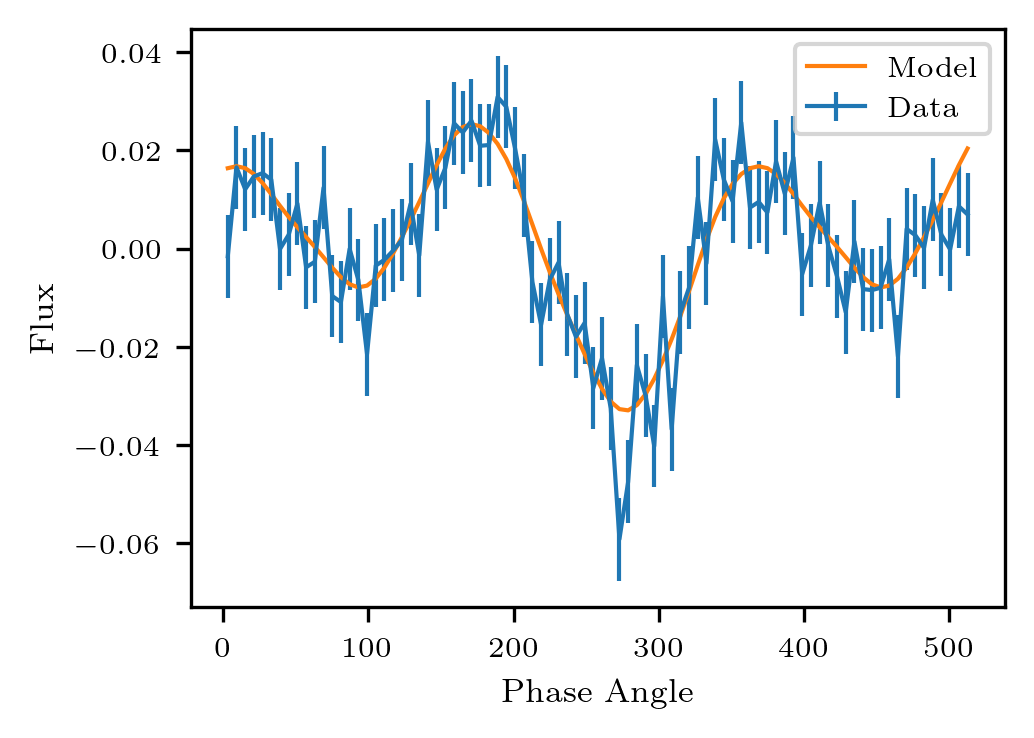

In [6]:
map.plot_lightcurve()

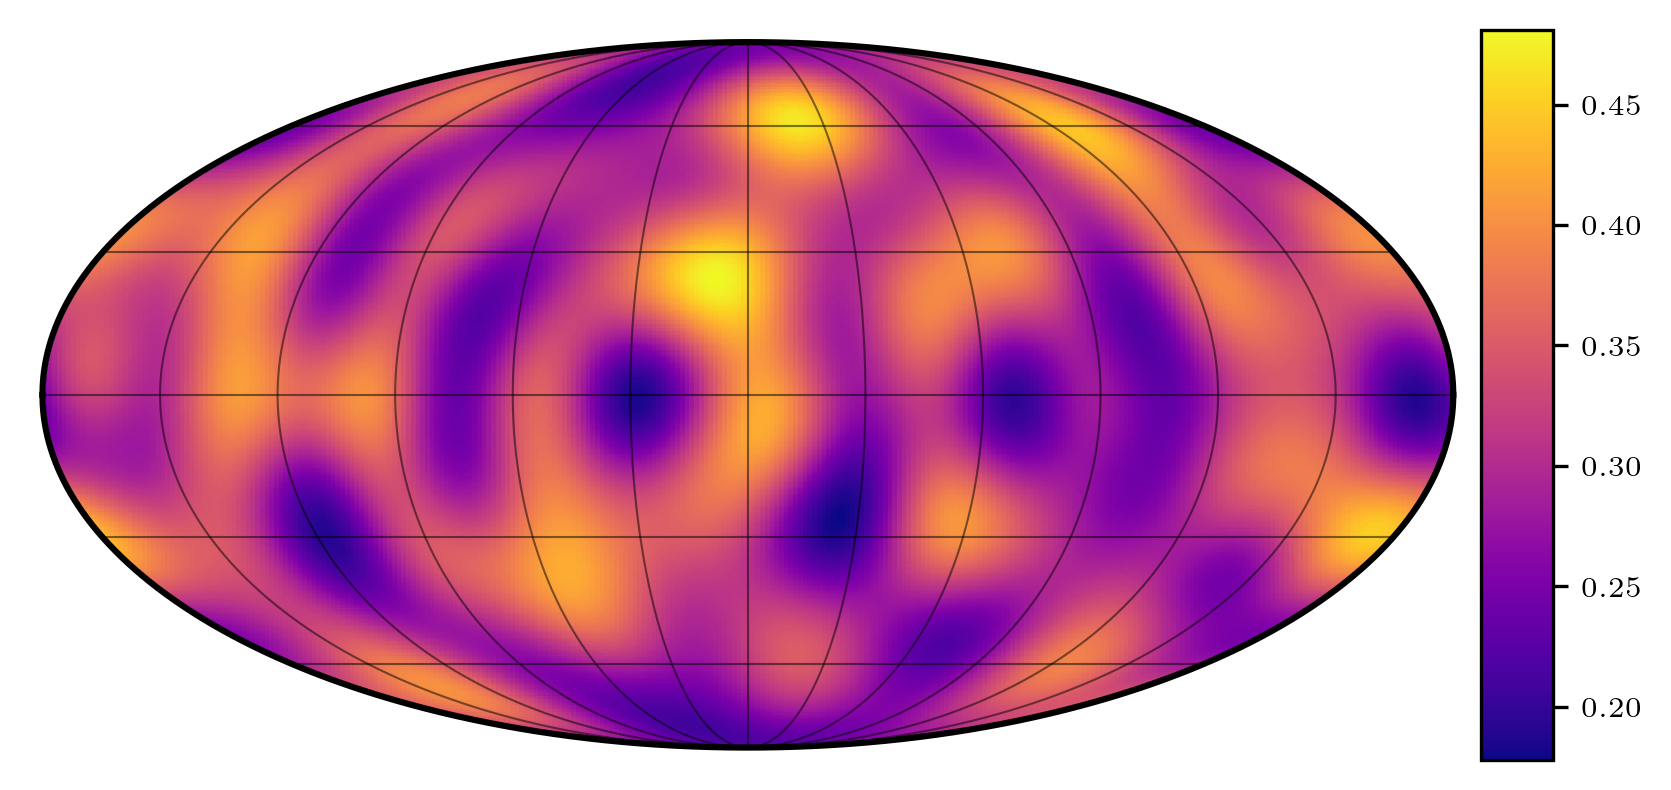

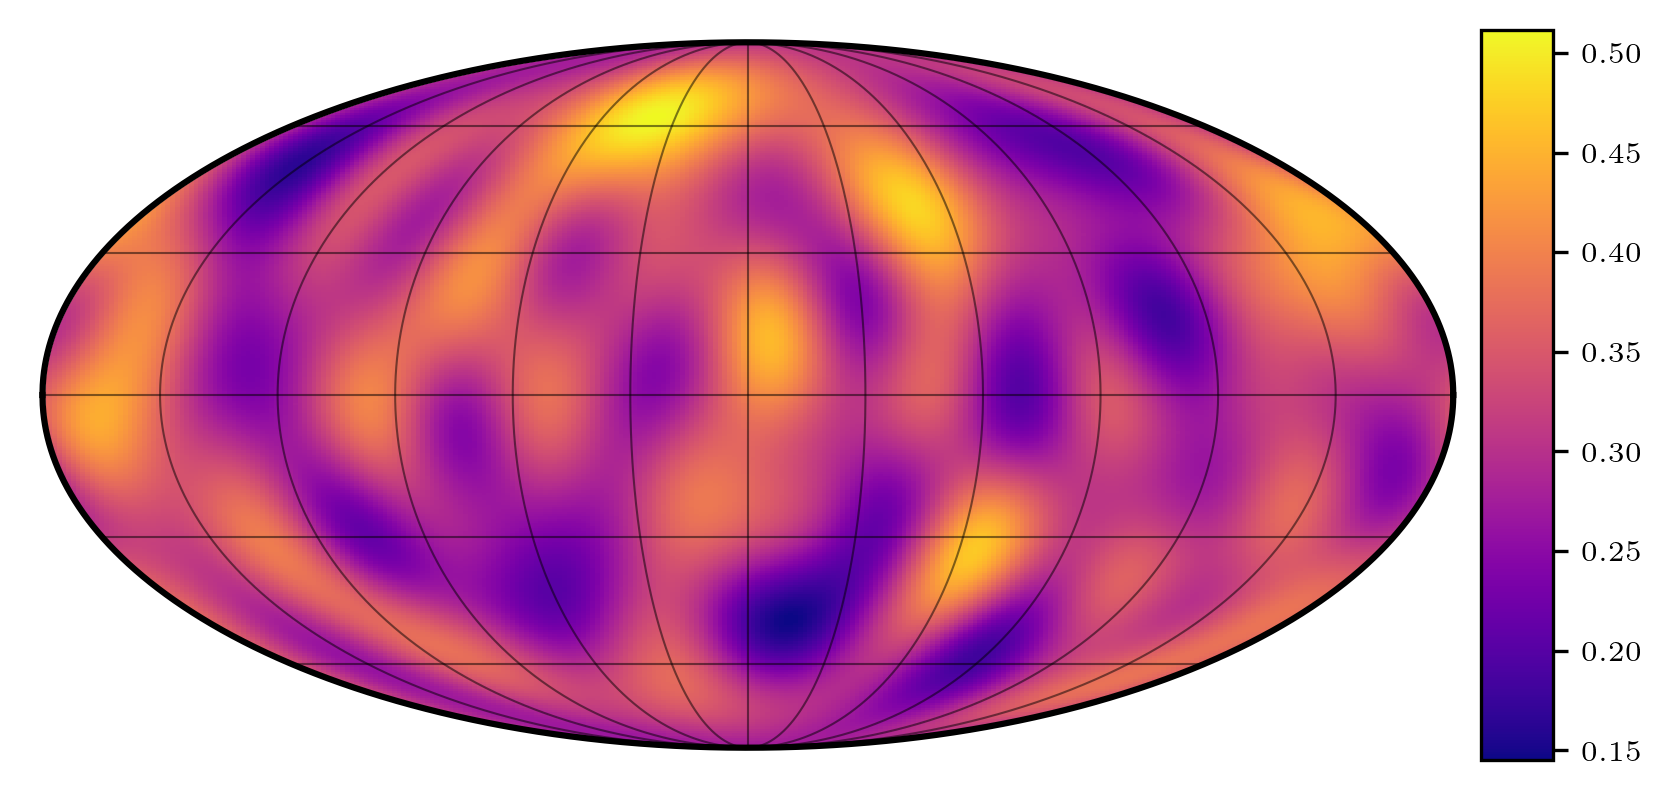

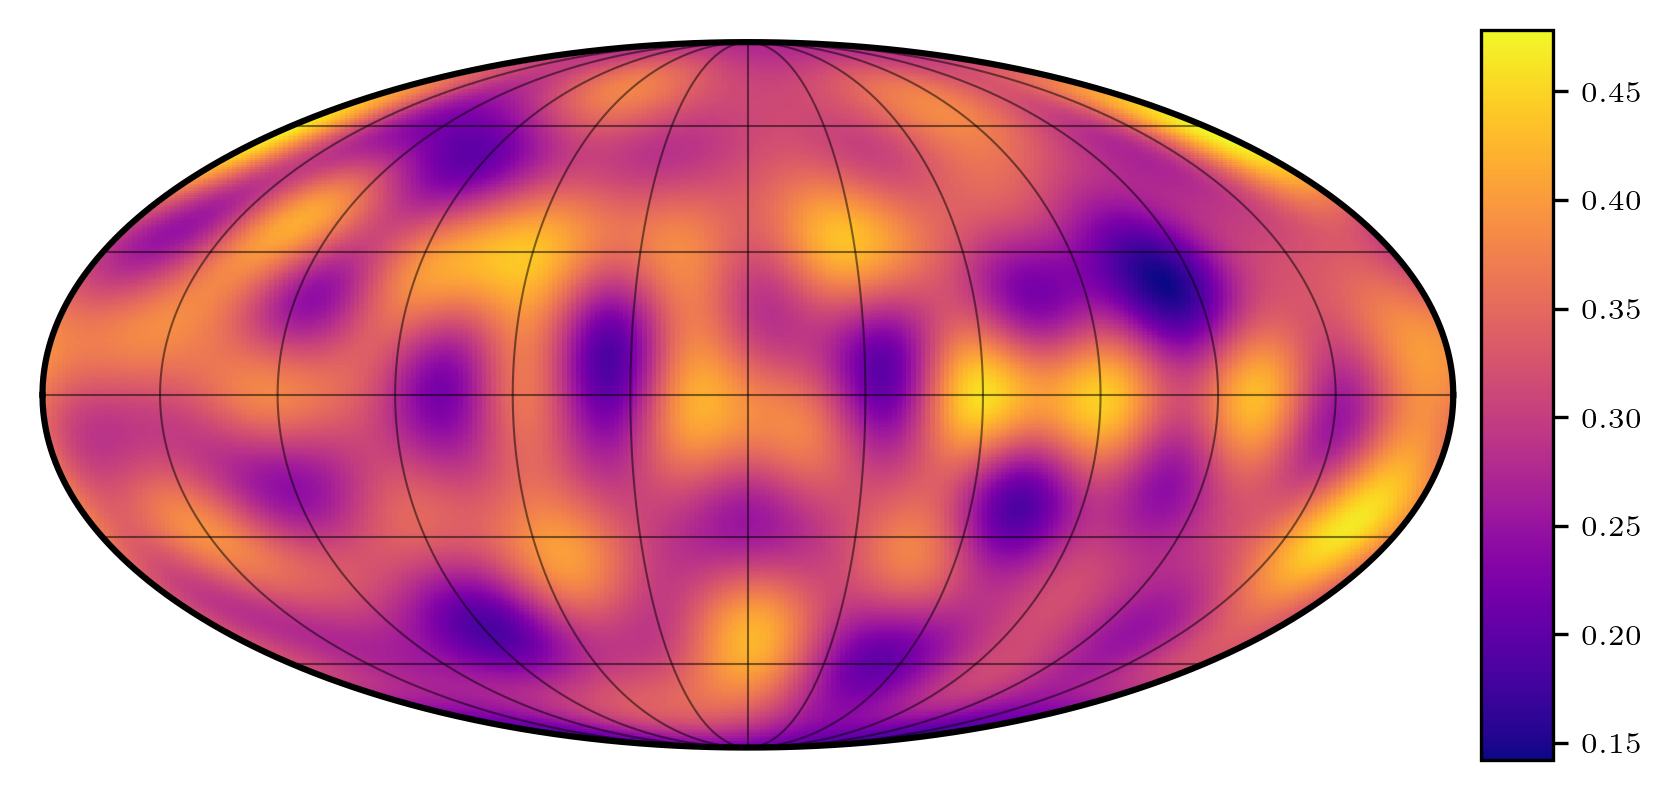

array([[ 2.76169941e-02, -3.45728285e-03, -1.15888680e-02,
         2.55664918e-02,  8.40159906e-03,  3.60164722e-02,
        -1.28782192e-05, -1.11499455e-02, -4.37436157e-03,
         2.96216892e-02,  1.56493105e-02,  2.05232256e-02,
        -3.73511076e-03, -5.73372236e-03, -2.19526959e-02,
        -6.86297126e-03, -3.29876463e-02,  2.30048253e-04,
         2.31616132e-02, -2.96708282e-02, -7.21772506e-03,
        -1.45374288e-02,  1.64667942e-02, -1.60560153e-02,
         8.64547758e-04,  7.04274502e-03,  3.53813339e-03,
         6.38319692e-04,  1.02290673e-03,  2.62624276e-02,
        -8.64759071e-03, -2.39214300e-02,  2.49228748e-02,
        -1.80613800e-02, -9.71507036e-03,  2.94841523e-03,
         1.30862153e-02, -7.24206265e-04,  7.81288539e-03,
        -1.37251946e-02,  9.48318322e-03,  8.38727076e-03,
         8.96040500e-03, -2.52611067e-02,  2.54950799e-03,
         1.80814598e-03,  2.39498702e-02, -3.74525884e-03,
        -1.22842666e-04,  1.45189299e-04,  1.53084715e-0

In [7]:
map.draw(plot=True, projection="moll", grid=True, colorbar=True, n_samples=3)

### Find Optimal Map Complexity
We now solve for the maps. Since we don't know the complexity of the surface beforehand, we test spherical harmonic degrees ranging from `ydeg=2` to `ydeg=10`. The algorithm will automatically select the degree that best fits the data without overfitting (using the Bayesian Information Criterion).

In [8]:


# Solve for the best spherical harmonic degree (ydeg) for each wavelength
# This optimizes the model complexity (BIC) to avoid overfitting
ydeg_best, I_all_wl, I_cov_all_wl = best_ydeg_maps(data, ydeg_min=2, ydeg_max=10)

print("Best Spherical Harmonic Degree per wavelength bin:")
print(ydeg_best)

KeyboardInterrupt: 

In [ ]:
from spectralmap.mapping import fit_ydeg_range
ydeg_range, log_evs, coeffs_means, coeffs_covs, log_evs = fit_ydeg_range(data, ydeg_min=2, ydeg_max=10)

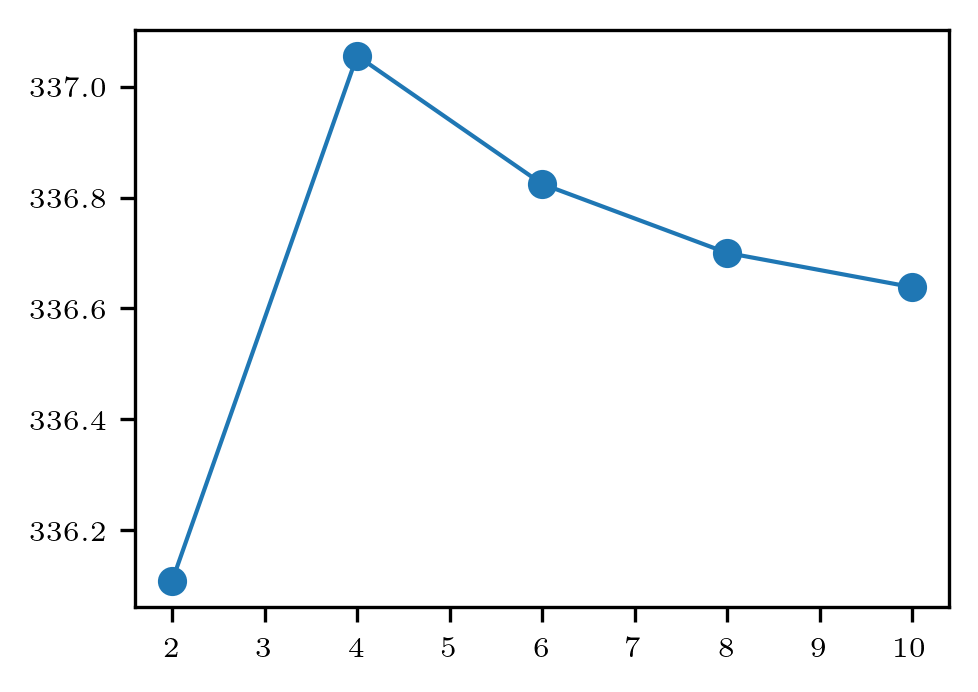

In [ ]:
plt.plot(ydeg_range, log_evs[:, 100], marker='o')

## 3. Visualize the Maps
Let's take a look at the recovered maps for a few wavelengths to see how the surface features change.

In [ ]:
# for i, ydeg in enumerate(ydeg_best[:10]):
#     if ydeg <= 5:
#         plt.figure()
#         plt.imshow(I_all_wl[i].reshape((30, 30)), origin='lower')
#         plt.title(f"Wavelength {wl_B[i]: .2f}: best ydeg = {ydeg}")

## 4. Spectral Extraction
We convert the retrieved intensity maps ($I$) back into physical flux units ($F$) and calculate the associated variances. This gives us the spatially-resolved spectra.

In [ ]:
F_all_wl = I_all_wl * amplitudes[:, None] *np.pi
F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)

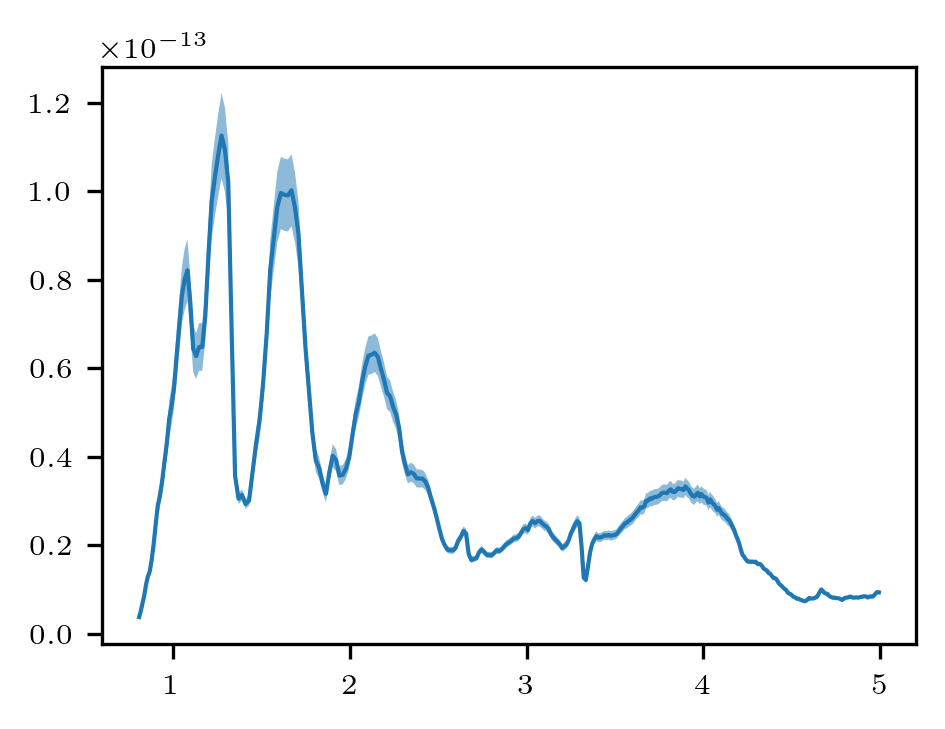

In [ ]:
import matplotlib.pyplot as plt
i_grid = 300
plt.plot(wl_B[:], F_all_wl[:, i_grid])
plt.fill_between(wl_B[:], F_all_wl[:, i_grid] - np.sqrt(F_var_all_wl[:, i_grid]), F_all_wl[:, i_grid] + np.sqrt(F_var_all_wl[:, i_grid]), alpha=0.5)

## 5. Clustering and Regional Identification
To make sense of the map, we group pixels that show similar spectral behavior using a clustering algorithm. This helps us identify distinct "regions" or features on the object's surface.

Step 1 (Corners: 13): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 2 (Corners: 12): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 3 (Corners: 11): Loss 6 vs Prev 2 (Ratio: 3.0)
Step 4 (Corners: 10): Loss 6 vs Prev 6 (Ratio: 1.0)
Step 5 (Corners: 9): Loss 7 vs Prev 6 (Ratio: 1.2)
Step 6 (Corners: 8): Loss 10 vs Prev 7 (Ratio: 1.4)
Step 7 (Corners: 7): Loss 12 vs Prev 10 (Ratio: 1.2)
Step 8 (Corners: 6): Loss 15 vs Prev 12 (Ratio: 1.2)
Step 9 (Corners: 5): Loss 58 vs Prev 15 (Ratio: 3.9)
Step 10 (Corners: 4): Loss 59 vs Prev 58 (Ratio: 1.0)
Step 11 (Corners: 3): Loss inf vs Prev 59 (Ratio: inf)
-> Elbow detected at 3 corners!
-1 750
0 50
1 50
2 50


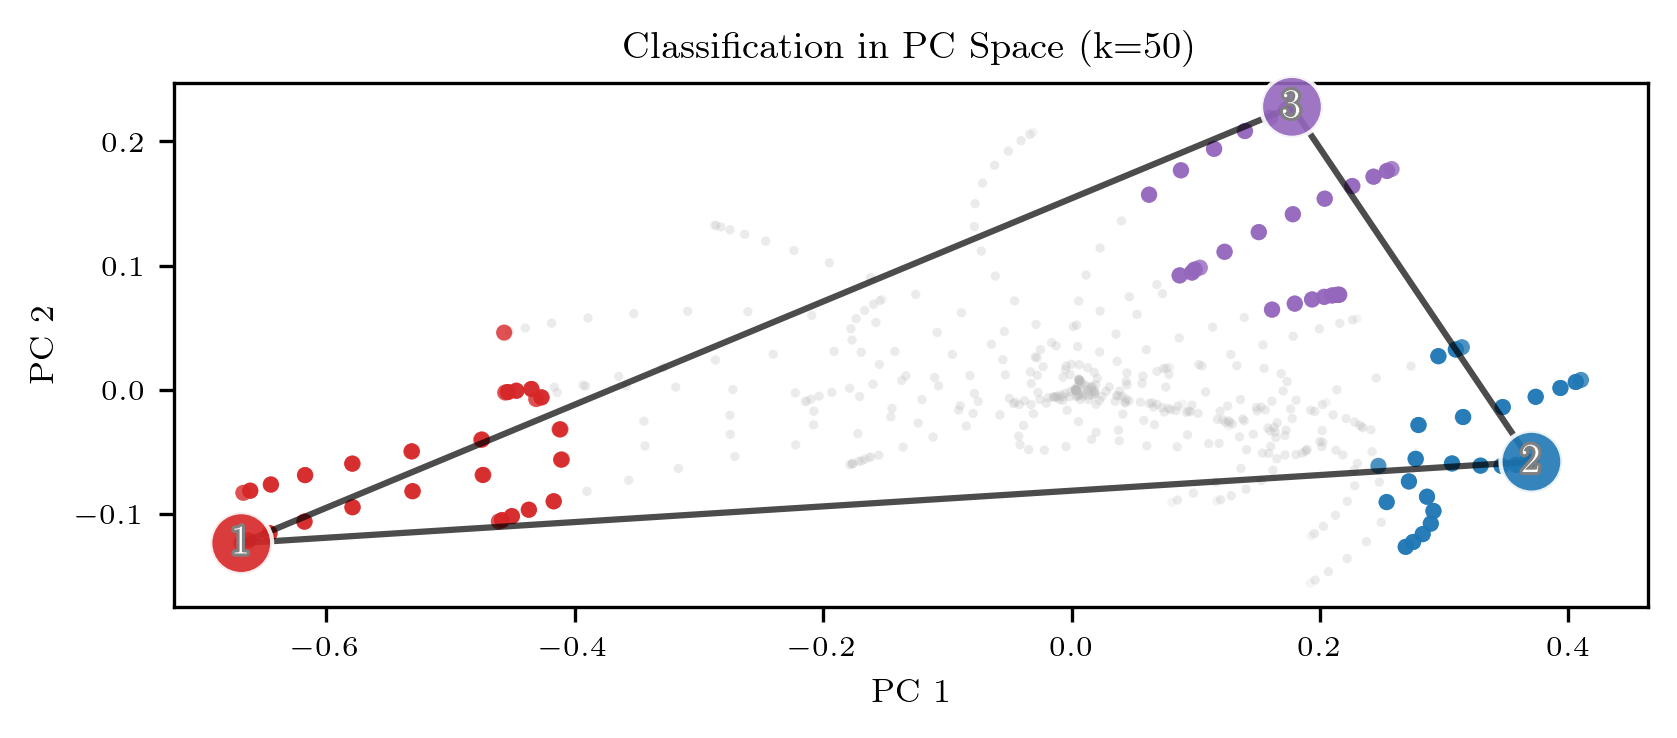

In [ ]:
from spectralmap.cluster import find_clusters
F_regionals, F_regional_errs, labels = find_clusters(F_all_wl, F_cov_all_wl, n_neighbors=50)
N = len(F_regionals)

## 6. Results
Finally, we visualize the identified clusters on the map and plot the mean spectrum for each region.

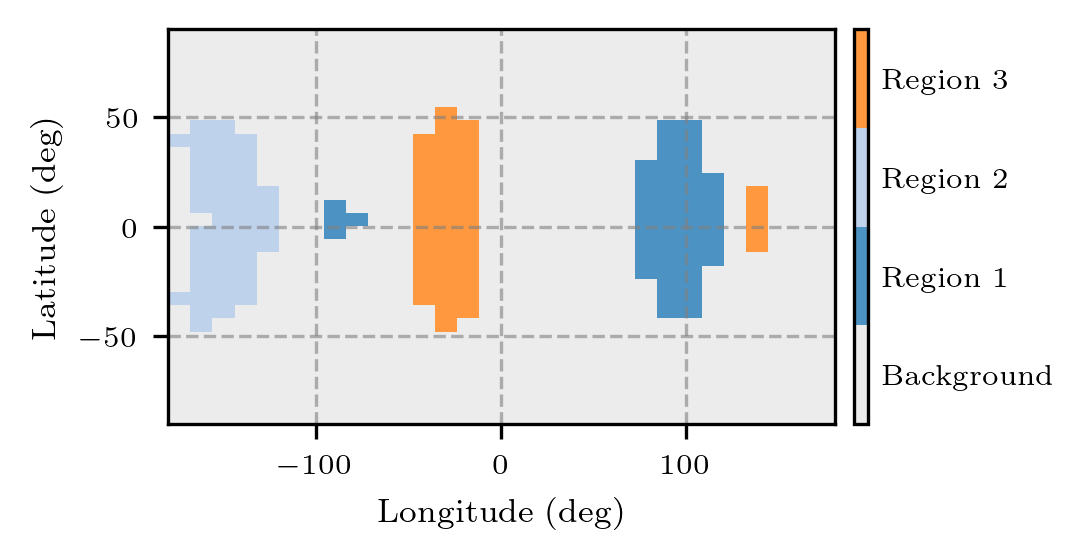

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- 1. SETUP & MOCK DATA ---
# (Assuming spectra.shape and lat are defined as per previous context)
map_res = int(np.sqrt(F_all_wl.shape[-1]))

# Create Mock "Assigned" Labels (for the contour overlay)
# We shift it slightly so the dotted lines are visible against the background
labels_assigned = labels.reshape(map_res, map_res).T.astype(np.float64)
# --- 2. STYLE DEFINITIONS ---
# Automatically create contrasting colors for N clusters
# We'll use a fixed color for the background (-1) and distinct colors for regions
colors_list = ['#E8E8E8'] # Light gray for Background
# Use tab20 for distinct region colors
region_colors = plt.get_cmap('tab20').colors 

for i in range(N-1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N-1)]

cmap = mcolors.ListedColormap(colors_list)

# --- 3. PLOTTING ---
# Single plot
fig, ax = plt.subplots(figsize=(3.5, 3.5 * (180/360)), dpi=300, constrained_layout=True)

# A. Plot Ground Truth (Input) as filled image
im = ax.imshow(
    labels_assigned.T,
    origin='lower',
    cmap=cmap,
    vmin=-1.5, vmax=N-1.5,  # Centers colors on -1, 0, 1, 2, 3
    extent=[-180, 180, -90, 90], 
    alpha=0.8,
    aspect='auto'
)


# Add grid
ax.grid(True, linestyle='--', color='gray', alpha=0.6) 

# Titles and Labels
ax.set_ylabel("Latitude (deg)", fontsize=8)
ax.set_xlabel("Longitude (deg)", fontsize=8)
# ax.set_title("Recovered", fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=7)

# --- COLORBAR ---
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.03, aspect=30)
cbar.set_ticks(np.arange(N)-1)  # Center ticks on each color
cbar.ax.set_yticklabels(cluster_names, fontsize=7)
cbar.ax.yaxis.set_tick_params(length=0) 
cbar.outline.set_edgecolor('black')

output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "S0136_recovered_regions.pdf")
plt.savefig(output_path, dpi=300)

Plot saved to paper_plots/S0136_recovered_spectra.pdf


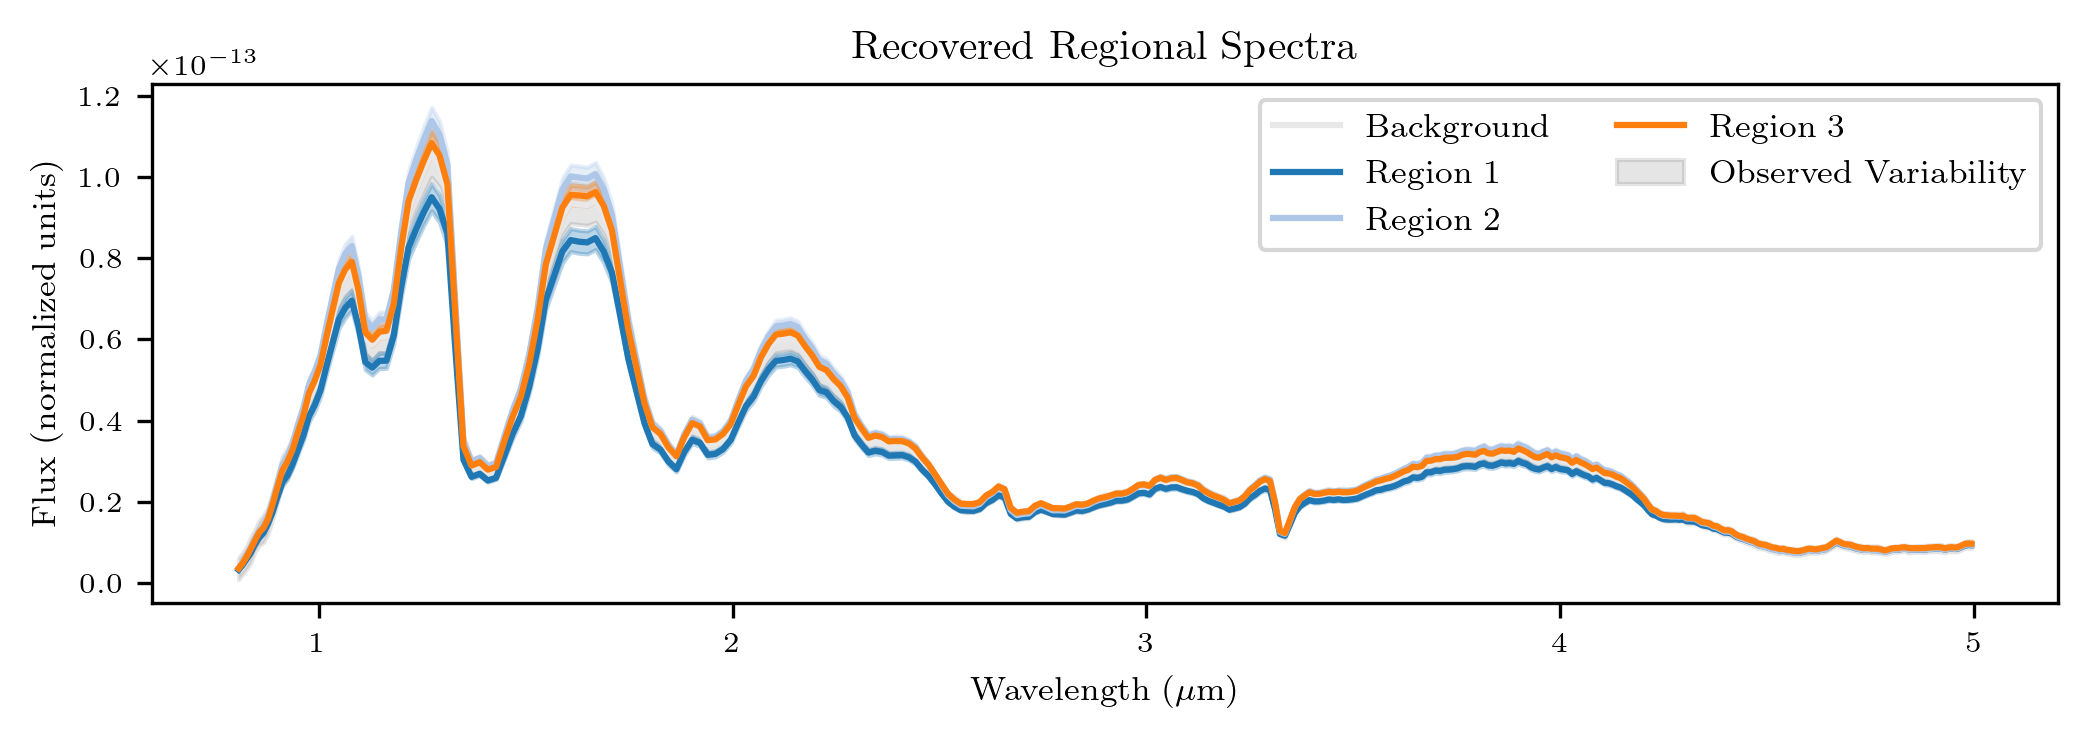

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import os

fig, ax = plt.subplots(figsize=(7, 2.5))

# Plot the recovered spectra for each region
for i in range(N):
    mean_flux = F_regionals[i]
    error_flux = F_regional_errs[i] # Fixed variable name
    color = colors_list[i]
    label = cluster_names[i]
    
    ax.plot(wl_B, mean_flux, label=f"{label}", color=color, linewidth=1.5)
    ax.fill_between(wl_B, 
                    mean_flux - error_flux, 
                    mean_flux + error_flux, 
                    alpha=0.3, color=color)
    
# Overlay the range of the observed time-series variability
time_series = np.sort(LC_B.T, axis=0)
ax.fill_between(wl_B, time_series[0, :],
            time_series[-1, :], color='black', alpha=0.1, zorder=0, label="Observed Variability")

# Formatting
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel("Flux (normalized units)")
ax.set_title("Recovered Regional Spectra", fontsize=10)
ax.legend(fontsize=8, loc='upper right', ncol=2)

plt.tight_layout()

output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "S0136_recovered_spectra.pdf")
plt.savefig(output_path, dpi=600)
print(f"Plot saved to {output_path}")

plt.show()